# Deep Learning: Ex.7 - **Features visualization**

Submitted by: Noam Bassat 308465434



In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
from seaborn import heatmap 

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.4.0


---
### 1. Activation maps

In this question we will explore the qualitative differences between activation maps, in different layers, along the VGG-16 model.

- load the pre-trained VGG model.
- load and preprocess the sample cat image.
- plot the corresponding activations of 10 filters (out of the 64 filters) of the `block1_conv2` layer (note: this is the 2nd conv layer in the model). use 10 subplots in a single row (the `hot` colormap gives a nice output).
- repeat the process for the following layers (the last conv layer in each VGG block): `block2_conv2`, `block3_conv3`, `block4_conv3`, `block5_conv3`.

- Describe in words (English/Hebrew) what is the main difference you see when "climbing" the network layers?



<h2> As we progress deeper into the model, the feature plot shows less and less detail, the neurons appear more and more sparse.</h2>

In [2]:
vgg16 = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                               include_top=True,
                                               weights='imagenet')

In [3]:
image = load_img('cat016.jpg', target_size=(224, 224)) 
img = img_to_array(image)  # convcert to NumPy
img = img[None]
img = preprocess_input(img)
print('img.shape =',img.shape)

img.shape = (1, 224, 224, 3)


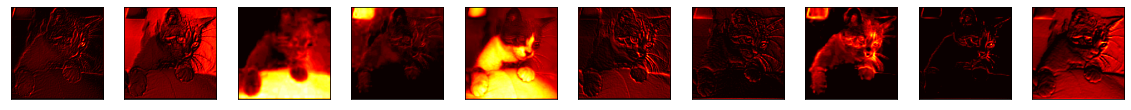

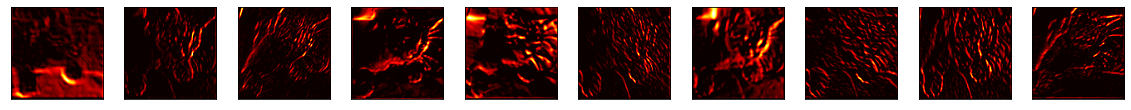

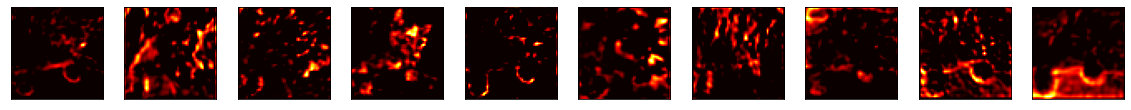

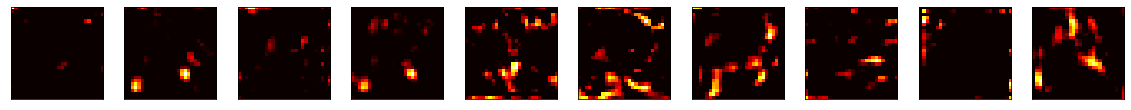

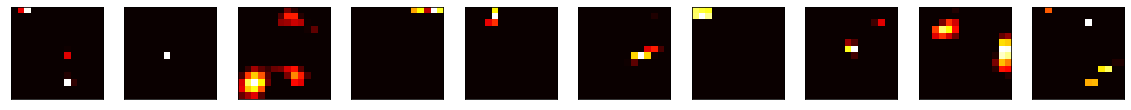

In [4]:
def plot_layer(layer_num):
    activations = keras.Model(inputs=vgg16.inputs, outputs=vgg16.layers[layer_num].output)
    a = activations.predict(img)
    plt.figure(figsize=(20,20))
    for i in range(10):
        plt.subplot(10,10,i+1)
        plt.imshow(a[0,:,:,i], cmap='hot')
        plt.xticks([])
        plt.yticks([])
layers_ = [2,5,9,13,17]
for layer in layers_:
    plot_layer(layer)

---
### 2. VGG-16 as a feature extractor

In this question we will use the VGG-16 model (pre-trained on the ImageNet dataset) as a smart feature-extractor.
To this aim, we will use its output from the FC layer (`fc2`) before its last one. This layer produces a 4096-D vector for any given image input of size (224,224,3).

- We will use this method, to extract a 4096-D features representation, for each of the 170 flowers images in the flower17 validation set, resulting in a features matrix of size: 170x4096.

Note: use `tf.keras.applications.vgg16.preprocess_input` to process each of the images (like we did in class8.ipynb), to match the same preprocessing step used while training this VGG-16 model.

- Calculate and plot the pair-wise distance matrix (of size: 170x170) between all these features. Can you spot the groups of different flowers types? Add a grid (`plt.grid()`) to the plot, with corresponding lines (use: `plt.xticks` and `plt.yticks`), to emphasize the flowers groups.

- Use the t-SNE algorithm to reduce the dimensionality of the features (from 4096-D to 2-D), and use a scatter plot to visualize all 170 samples in this 2-D space. Color the samples by their true label (use the `tab20` color map).


In [5]:
features_extractor = keras.Model(inputs=vgg16.inputs, outputs=vgg16.layers[-2].output)
yhat = vgg16.predict(img) 

In [6]:
!git clone https://github.com/rubinj/Flowers-17.git

fatal: destination path 'Flowers-17' already exists and is not an empty directory.


In [7]:


dataGen = ImageDataGenerator(preprocessing_function=preprocess_input) # tf.keras.applications.vgg16.preprocess_input

testGen = dataGen.flow_from_directory('Flowers-17/validation/', target_size=(224,224), batch_size=60, shuffle=False)

Found 170 images belonging to 17 classes.


In [8]:
features_4096D = features_extractor.predict(testGen)

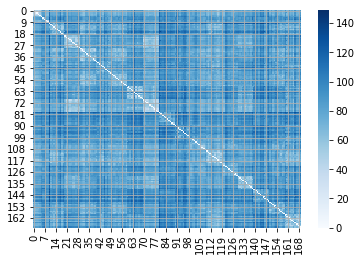

In [9]:
dist = pairwise_distances(features_4096D,metric='euclidean')
plt.grid(heatmap(dist, cmap='Blues'))
plt.xticks()
plt.yticks()
plt.show()

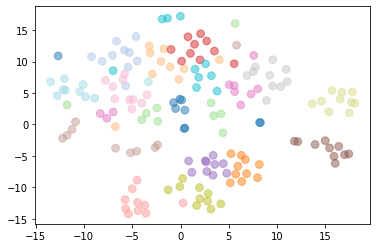

In [10]:
features_2D = TSNE(n_components=2).fit_transform(features_4096D)
plt.scatter(features_2D[:,0], features_2D[:,1], s=60, c=testGen.classes, 
            cmap='tab20', alpha=0.5)


plt.show()

---
### 3. Maximally activating patches

In this question, we will try to explore the different filters along a ConvNet model ("VGG-like").

We will use a ConvNet model (very similar to the one you trained in Ex.5) that was pre-trained on the CIFAR-10 dataset (you will need to download the model and put it in your working directory).

This model consists of the following layers: 

 - input (32x32x3) -> (Conv -> Conv -> Pool) -> (Conv -> Conv -> Pool) -> (Conv -> Conv -> Pool) -> 2048-Dense -> 10-output
 
There are also some batch-normalization and dropout layers in between. All `Conv2D` layers use 3x3 kernels with `padding='same'`.

We will use the 10,000 validation images of the CIFAR-10 dataset for the following analysis.

- pick the 2nd conv layer in the model (`conv2d_1`), calculate its activation pattern for each of the 10,000 images. 
- pick the 1st filter (channel) in that layer (out of the 32 available), and look for the 6 highest activations there. (note: in class we picked the highest activation, here you need to sort them and pick the 6 highest.). for each of these highest activations, plot the corresponding patch that elicited that excited response.

- repeat the same process for 7 more filters (channels) in the same layer (`conv2d_1`). Plot 6 patches (maximally activating) for each of the 7 filters (total 6x8 patches, including the 1st filter from before).  

- Finally, repeat the whole process for two more layers in the model: `conv2d_2` and `conv2d_3`. For each of these two layers, pick 8 filters (channels), and find the 6 maximally activating patches for each filter.

Pay careful attention to the way you transform the index `(i,j)` in the activation layer to the correct patch in the image.. 

You should get results similar to the ones in the presentation slides.


In [11]:
# first download the model and put it in your working directory, then load it:
model = tf.keras.models.load_model('cifar_model') 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [20]:
# load the 10,000 validation images from CIFAR-10:

from tensorflow.keras.datasets import cifar10
(_, _), (x_test, y_test) = cifar10.load_data()

print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_test.shape =  (10000, 32, 32, 3)
y_test.shape =  (10000, 1)


In [28]:
def plot_idx(filter_id,n,padding_flag,square):
    activations_extractor = Model(inputs = model.input, outputs = model.layers[n].output)

    activations = activations_extractor.predict(x_test)

    plt.figure(figsize=(14,6))
    arr = activations[:,:,:,filter_id].copy()
    top_k_index_list = [ ]
    for i in range(6):
        cur_max = np.argmax(arr)
        top_k_index_list.append(cur_max)
        (img_idx, i, j) = np.unravel_index(cur_max, arr.shape[:3])
        arr[img_idx][i][j] = -float('inf')


       
        for ii,idx in enumerate(top_k_index_list):
            plt.subplot(1,6,ii+1)
            (img_idx, i, j) = np.unravel_index(idx, activations.shape[:3])
            img = x_test[img_idx]
            if(padding_flag == 1):
                img_padded = np.pad(img,((2,2),(2,2),(0,0)))
            if(padding_flag==2):
                img_padded = np.pad(img,((4,4),(4,4),(0,0)))
            if(padding_flag==3):   
                 img_padded = np.pad(img,((6,6),(6,6),(0,0)))
            patch = img_padded[i:i+square, j:j+square, :]
            ### 2_1: square = 5
            ### 2_2: square = 10
            ### 2_3: square = 14
            plt.imshow(patch);


<ipython-input-28-041aa45096a6>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,6,ii+1)


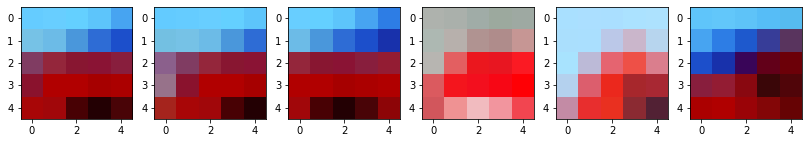

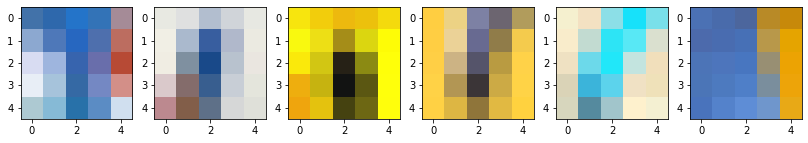

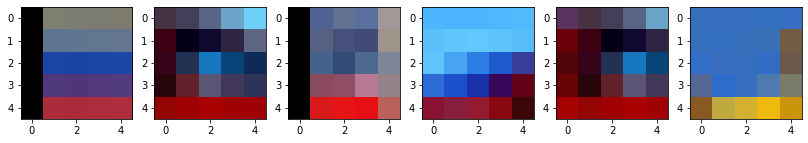

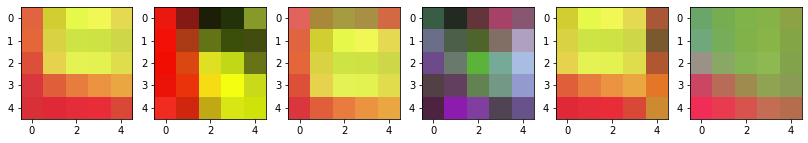

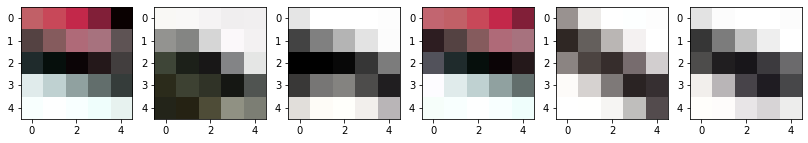

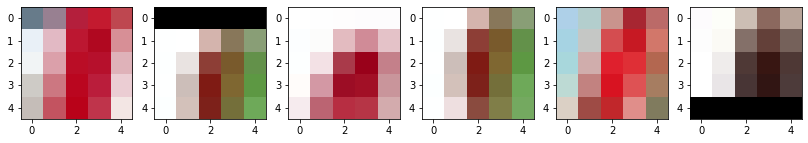

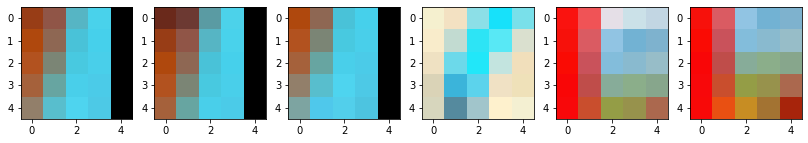

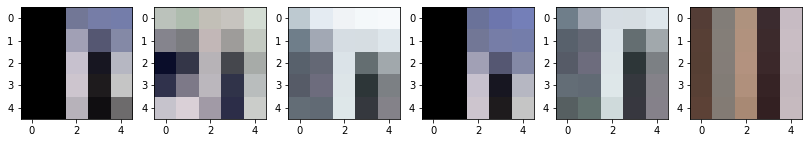

In [29]:
for filter_id in [1,2,3,4,5,6,7,8]: 
    plot_idx(filter_id,2,1,5) ### conv2d_1:  5X5

<ipython-input-28-041aa45096a6>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,6,ii+1)


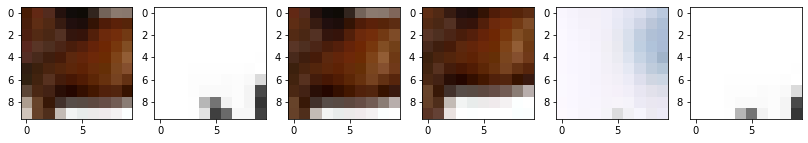

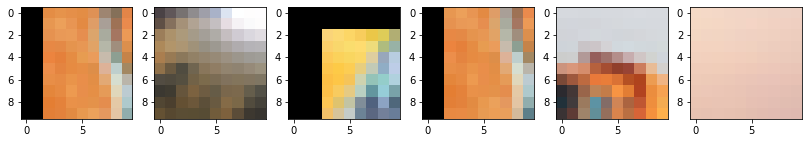

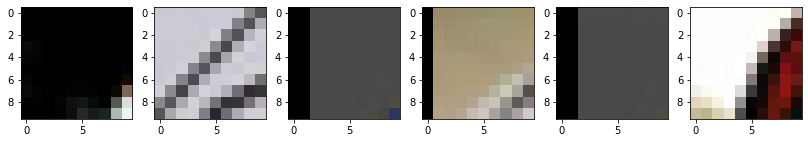

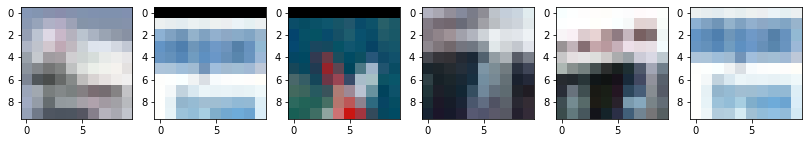

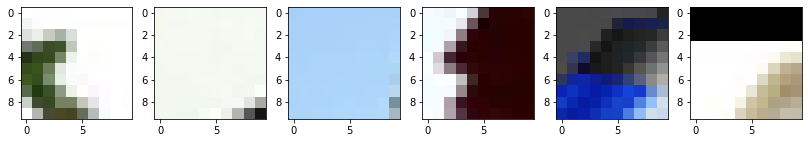

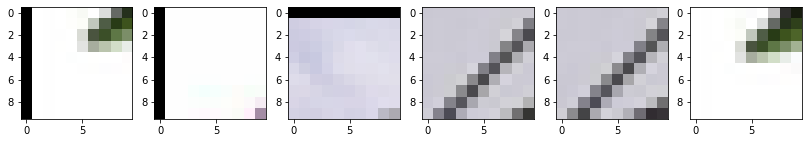

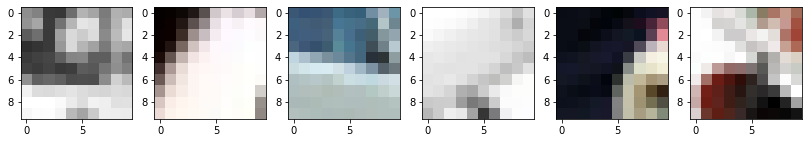

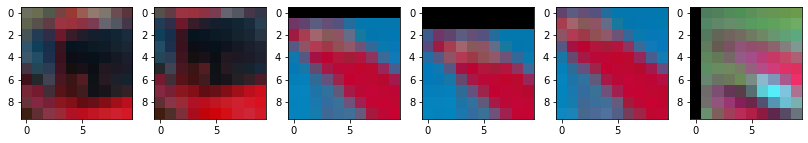

In [30]:
for filter_id in [1,2,3,4,5,6,7,8]: 
     plot_idx(filter_id,6,2,10) ###conv2d_2 10X10

<ipython-input-28-041aa45096a6>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,6,ii+1)


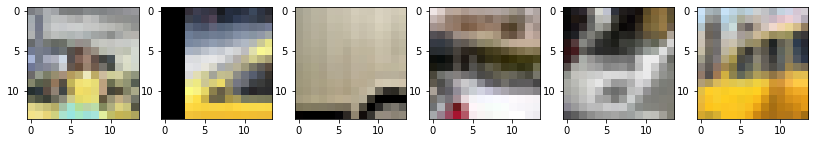

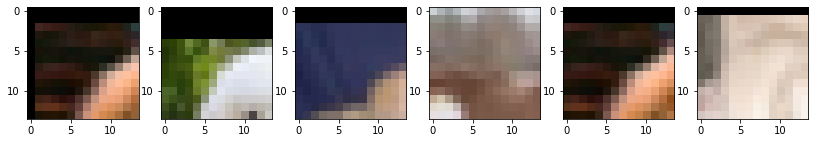

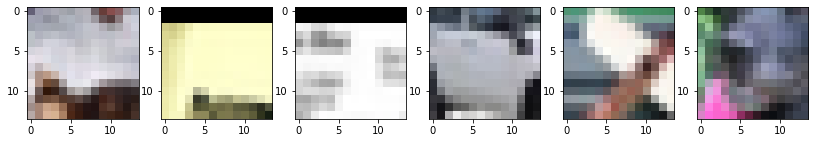

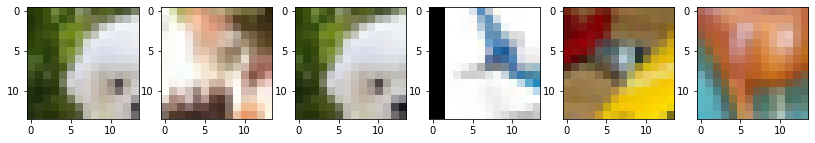

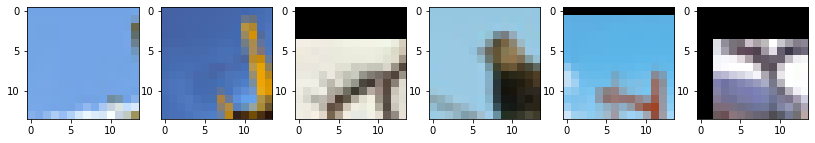

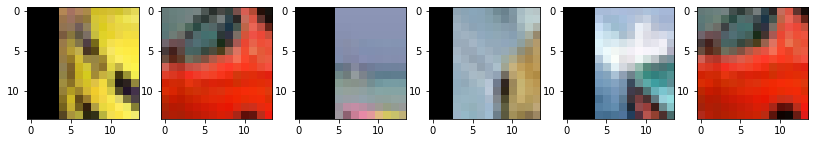

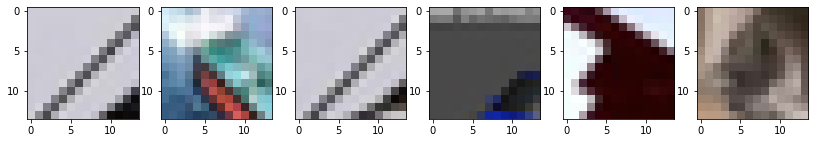

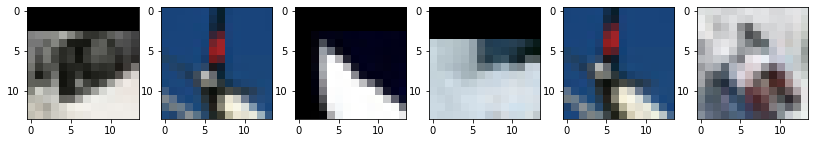

In [31]:
for filter_id in [1,2,3,4,5,6,7,8]: 
     plot_idx(filter_id,8,3,14) ###conv2d_3 14X14

***
## Good Luck!

Thanks!